# Redoing Weka Stuff

In this section we will try to redo some of the things we have already done in Weka.
Objective: To try out some familiar algorithms for classification and regression in python using its libraries.

## Imports

I always try to import all the useful libraries upfront. It is also considered a good practice in programming community.

In [1]:
%matplotlib inline
import numpy as np
from scipy.io import arff
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import patsy
import statsmodels.api as sm

from sklearn import tree, linear_model, metrics, dummy, naive_bayes, neighbors

from IPython.display import Image
import pydotplus

In [2]:
sns.set_context("paper")
sns.set_style("ticks")

def load_arff(filename):
    data, meta = arff.loadarff(filename)
    df = pd.DataFrame(data, columns=meta.names())
    for c, k in zip(df.columns, meta.types()):
        if k == "nominal":
            df[c] = df[c].astype("category")
        if k == "numeric":
            df[c] = df[c].astype("float")        
    return df

def get_confusion_matrix(clf, X, y, verbose=True):
    y_pred = clf.predict(X)
    cm = metrics.confusion_matrix(y_true=y, y_pred=y_pred)
    clf_report = metrics.classification_report(y, y_pred)
    df_cm = pd.DataFrame(cm, columns=clf.classes_, index=clf.classes_)
    if verbose:
        print clf_report
        print df_cm
    return clf_report, df_cm

def show_decision_tree(clf, X, y):
    dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=X.columns,  
                         class_names=y.unique(),  
                         filled=True, rounded=True,  
                         special_characters=True, impurity=False)  
    graph = pydotplus.graph_from_dot_data(dot_data)  
    return Image(graph.create_png())


def plot_decision_regions(clf, X, y, col_x=0, col_y=1,
                          ax=None, plot_step=0.01, colors="bry"):
    if ax is None:
        fig, ax = plt.subplots()
    x_min, x_max = X[col_x].min(), X[col_x].max()
    y_min, y_max = X[col_y].min(), X[col_y].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    b, Z = np.unique(Z, return_inverse=True)
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    for i, l in enumerate(clf.classes_):
        idx = np.where(y==l)[0]
        ax.scatter(X.ix[idx, col_x], X.ix[idx, col_y], label=l, c=colors[i], cmap=plt.cm.Paired)
    ax.set_xlabel(col_x)
    ax.set_ylabel(col_y)
    ax.legend(bbox_to_anchor=(1.2, 0.5))
    fig.tight_layout()
    return ax


In [3]:
df = load_arff("../data/iris.arff")
print df.shape
df.head()

(150, 5)


,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
df.dtypes

sepallength     float64
sepalwidth      float64
petallength     float64
petalwidth      float64
class          category
dtype: object

## Feature creations - Math Expressions

In [5]:
df_t = df.copy() ## Since we are going to edit the data we should always make a copy

In [6]:
df_t.head()

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [7]:
df_t["sepallength_sqr"] = df_t["sepallength"]**2 ## ** in python is used for exponent.
df_t.head()

,sepallength,sepalwidth,petallength,petalwidth,class,sepallength_sqr
0,5.1,3.5,1.4,0.2,Iris-setosa,26.01
1,4.9,3.0,1.4,0.2,Iris-setosa,24.01
2,4.7,3.2,1.3,0.2,Iris-setosa,22.09
3,4.6,3.1,1.5,0.2,Iris-setosa,21.16
4,5.0,3.6,1.4,0.2,Iris-setosa,25.00


In [8]:
df_t["sepallength_log"] = np.log10(df_t["sepallength"])
df_t.head()

,sepallength,sepalwidth,petallength,petalwidth,class,sepallength_sqr,sepallength_log
0,5.1,3.5,1.4,0.2,Iris-setosa,26.01,0.707570
1,4.9,3.0,1.4,0.2,Iris-setosa,24.01,0.690196
2,4.7,3.2,1.3,0.2,Iris-setosa,22.09,0.672098
3,4.6,3.1,1.5,0.2,Iris-setosa,21.16,0.662758
4,5.0,3.6,1.4,0.2,Iris-setosa,25.00,0.698970


## Creating many features at once using patsy

In [9]:
df_t = df_t.rename(columns={"class": "label"})
df_t.head()

,sepallength,sepalwidth,petallength,petalwidth,label,sepallength_sqr,sepallength_log
0,5.1,3.5,1.4,0.2,Iris-setosa,26.01,0.707570
1,4.9,3.0,1.4,0.2,Iris-setosa,24.01,0.690196
2,4.7,3.2,1.3,0.2,Iris-setosa,22.09,0.672098
3,4.6,3.1,1.5,0.2,Iris-setosa,21.16,0.662758
4,5.0,3.6,1.4,0.2,Iris-setosa,25.00,0.698970


In [13]:
y, X = patsy.dmatrices("label ~ petalwidth + petallength:petalwidth + I(sepallength**2)-1", data=df_t, return_type="dataframe")
print y.shape, X.shape

(150, 3) (150, 3)


In [14]:
y.head()

,label[Iris-setosa],label[Iris-versicolor],label[Iris-virginica]
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [15]:
X.head()

,petalwidth,petallength:petalwidth,I(sepallength ** 2)
0,0.2,0.28,26.01
1,0.2,0.28,24.01
2,0.2,0.26,22.09
3,0.2,0.30,21.16
4,0.2,0.28,25.00


In [16]:
model = sm.MNLogit(y, X)
res = model.fit()
res.summary()

         Current function value: 0.053951
         Iterations: 35


/content/smishra8/SOFTWARE/anaconda2/envs/datamining/lib/python2.7/site-packages/statsmodels/discrete/discrete_model.py:580: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  start_params = np.zeros((self.K * (self.J-1)))
/content/smishra8/SOFTWARE/anaconda2/envs/datamining/lib/python2.7/site-packages/statsmodels/discrete/discrete_model.py:1840: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  params = params.reshape(self.K, -1, order='F')
/content/smishra8/SOFTWARE/anaconda2/envs/datamining/lib/python2.7/site-packages/statsmodels/discrete/discrete_model.py:1756: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  params = params.reshape(self.K, -1, order='F')
/content/smishra8/SOFTWARE/anaconda2/envs/datamining/lib/python2.7/site-packages/statsmodels/discrete/discrete_model.py:1697: VisibleD

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  150
Model:                        MNLogit   Df Residuals:                      144
Method:                           MLE   Df Model:                            4
Date:                Thu, 13 Oct 2016   Pseudo R-squ.:                  0.9509
Time:                        19:13:27   Log-Likelihood:                -8.0926
converged:                      False   LL-Null:                       -164.79
                                        LLR p-value:                 1.394e-66
===========================================================================================
y=label[Iris-versicolor]       coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
petalwidth                   5.1590   1.69e+05   3.06e-05      1.000      -3.3e+05   3.3e+05
petallength:petalwidth      17.6445   1.78e+04      0.001      0.999     -3.49e+04   3.5e+04
I(sepallength ** 2)         -1.5079   3363.455     -0.000      1.000     -6593.758  6590.742
--------------------------------------------------------------------------------------------
y=label[Iris-virginica]       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
petalwidth                -18.1969   1.69e+05     -0.000      1.000      -3.3e+05   3.3e+05
petallength:petalwidth     24.2166   1.78e+04      0.001      0.999     -3.49e+04   3.5e+04
I(sepallength ** 2)        -1.8904   3363.455     -0.001      1.000     -6594.141  6590.360
===========================================================================================
"""

In [18]:
model_sk = linear_model.LogisticRegression(multi_class="multinomial", solver="lbfgs")
model_sk.fit(X, df_t["label"])


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
y_pred = model_sk.predict(X)

In [20]:
y_pred[:10]

array(['Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-setosa'], dtype=object)

In [21]:
print metrics.classification_report(df_t["label"], y_pred)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       0.94      0.94      0.94        50
 Iris-virginica       0.94      0.94      0.94        50

    avg / total       0.96      0.96      0.96       150



In [22]:
model_sk_t = tree.DecisionTreeClassifier()

In [24]:
model_sk_t.fit(X, df_t["label"])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

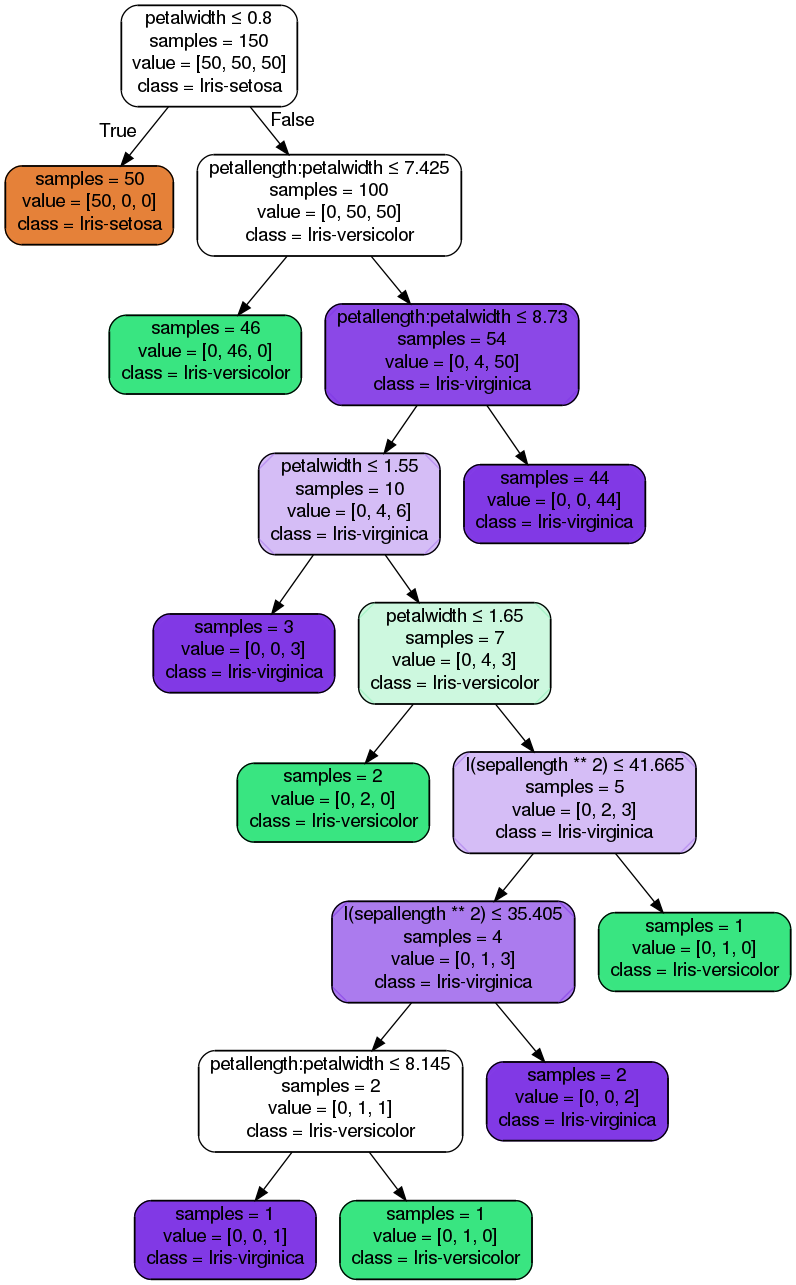

In [25]:
show_decision_tree(model_sk_t, X, df_t["label"])

In [26]:
model_0r = dummy.DummyClassifier(strategy="most_frequent")
model_0r.fit(X, df_t["label"])
y_pred = model_0r.predict(X)
print metrics.classification_report(df_t["label"], y_pred)

                 precision    recall  f1-score   support

    Iris-setosa       0.33      1.00      0.50        50
Iris-versicolor       0.00      0.00      0.00        50
 Iris-virginica       0.00      0.00      0.00        50

    avg / total       0.11      0.33      0.17       150



/content/smishra8/SOFTWARE/anaconda2/envs/datamining/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
cm = metrics.confusion_matrix(y_true=df_t["label"], y_pred=y_pred)

In [28]:
df_cm = pd.DataFrame(cm, columns=model_0r.classes_, index=model_0r.classes_)

In [29]:
df_cm

,Iris-setosa,Iris-versicolor,Iris-virginica
Iris-setosa,50,0,0
Iris-versicolor,50,0,0
Iris-virginica,50,0,0


In [30]:
_ = get_confusion_matrix(model_0r, X, df_t["label"])

                 precision    recall  f1-score   support

    Iris-setosa       0.33      1.00      0.50        50
Iris-versicolor       0.00      0.00      0.00        50
 Iris-virginica       0.00      0.00      0.00        50

    avg / total       0.11      0.33      0.17       150

                 Iris-setosa  Iris-versicolor  Iris-virginica
Iris-setosa               50                0               0
Iris-versicolor           50                0               0
Iris-virginica            50                0               0


In [31]:
_ = get_confusion_matrix(model_sk_t, X, df_t["label"])

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       1.00      1.00      1.00        50
 Iris-virginica       1.00      1.00      1.00        50

    avg / total       1.00      1.00      1.00       150

                 Iris-setosa  Iris-versicolor  Iris-virginica
Iris-setosa               50                0               0
Iris-versicolor            0               50               0
Iris-virginica             0                0              50


In [32]:
_ = get_confusion_matrix(model_sk, X, df_t["label"])

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       0.94      0.94      0.94        50
 Iris-virginica       0.94      0.94      0.94        50

    avg / total       0.96      0.96      0.96       150

                 Iris-setosa  Iris-versicolor  Iris-virginica
Iris-setosa               50                0               0
Iris-versicolor            0               47               3
Iris-virginica             0                3              47


## Plot decision regions

We can only do this if our data has 2 features

In [33]:
y, X = patsy.dmatrices("label ~ petalwidth + petallength - 1", data=df_t, return_type="dataframe") 
# -1 forces the data to not generate an intercept

In [34]:
X.columns

Index([u'petalwidth', u'petallength'], dtype='object')

In [35]:
y = df_t["label"]

In [36]:
clf = tree.DecisionTreeClassifier()
clf.fit(X, y)
_ = get_confusion_matrix(clf, X, y)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       1.00      0.98      0.99        50
 Iris-virginica       0.98      1.00      0.99        50

    avg / total       0.99      0.99      0.99       150

                 Iris-setosa  Iris-versicolor  Iris-virginica
Iris-setosa               50                0               0
Iris-versicolor            0               49               1
Iris-virginica             0                0              50


In [37]:
clf.feature_importances_

array([ 0.93507842,  0.06492158])

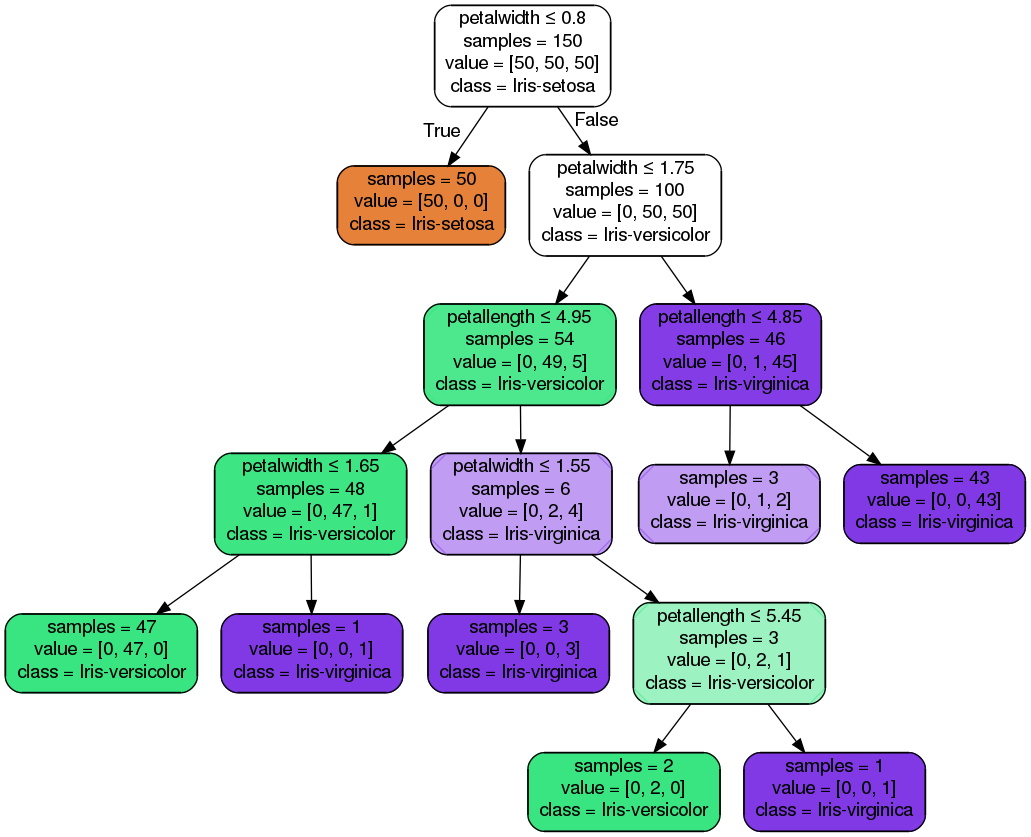

In [38]:
show_decision_tree(clf, X, y)

In [39]:
X.head()

,petalwidth,petallength
0,0.2,1.4
1,0.2,1.4
2,0.2,1.3
3,0.2,1.5
4,0.2,1.4


In [40]:
y.value_counts()

Iris-virginica     50
Iris-versicolor    50
Iris-setosa        50
Name: label, dtype: int64

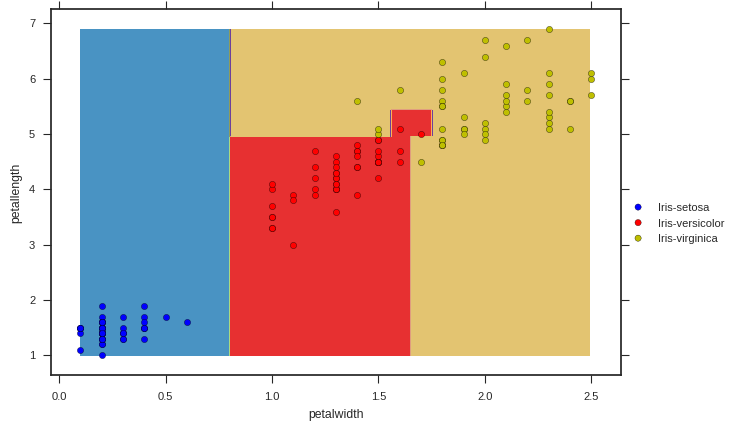

In [42]:
plot_decision_regions(clf, X, y, col_x="petalwidth", col_y="petallength")

## Naive Bayes classifier

In [43]:
clf = naive_bayes.GaussianNB()
clf.fit(X, y)
_ = get_confusion_matrix(clf, X, y)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       0.94      0.94      0.94        50
 Iris-virginica       0.94      0.94      0.94        50

    avg / total       0.96      0.96      0.96       150

                 Iris-setosa  Iris-versicolor  Iris-virginica
Iris-setosa               50                0               0
Iris-versicolor            0               47               3
Iris-virginica             0                3              47


**Decision surface of Naive Bayes classifier will not have overlapping colors because of the basic code I am using to show decision boundaries. A better code can show the mixing of colors properly**

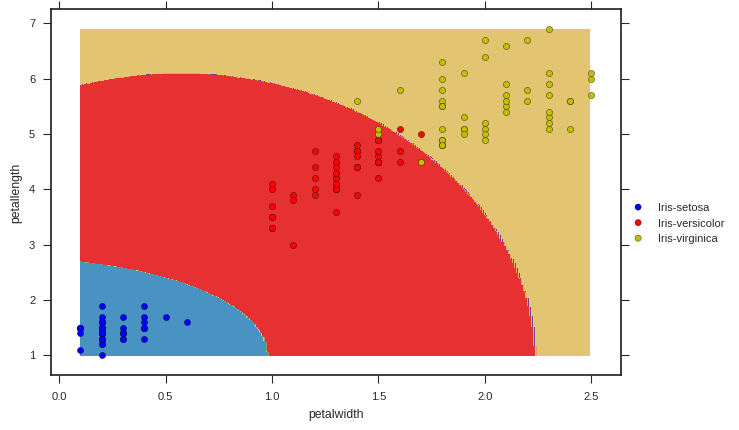

In [44]:
plot_decision_regions(clf, X, y, col_x="petalwidth", col_y="petallength")

## Logistic regression

In [45]:
clf = linear_model.LogisticRegression(multi_class="multinomial", solver="lbfgs")
clf.fit(X, y)
_ = get_confusion_matrix(clf, X, y)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       0.96      0.94      0.95        50
 Iris-virginica       0.94      0.96      0.95        50

    avg / total       0.97      0.97      0.97       150

                 Iris-setosa  Iris-versicolor  Iris-virginica
Iris-setosa               50                0               0
Iris-versicolor            0               47               3
Iris-virginica             0                2              48


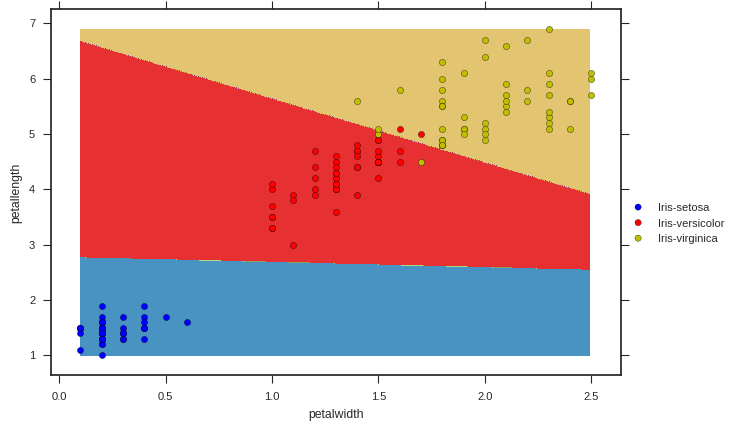

In [46]:
plot_decision_regions(clf, X, y, col_x="petalwidth", col_y="petallength")

## IBk of K-nearest neighbors classifier

In [47]:
clf = neighbors.KNeighborsClassifier(n_neighbors=1)
clf.fit(X, y)
_ = get_confusion_matrix(clf, X, y)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       1.00      0.98      0.99        50
 Iris-virginica       0.98      1.00      0.99        50

    avg / total       0.99      0.99      0.99       150

                 Iris-setosa  Iris-versicolor  Iris-virginica
Iris-setosa               50                0               0
Iris-versicolor            0               49               1
Iris-virginica             0                0              50


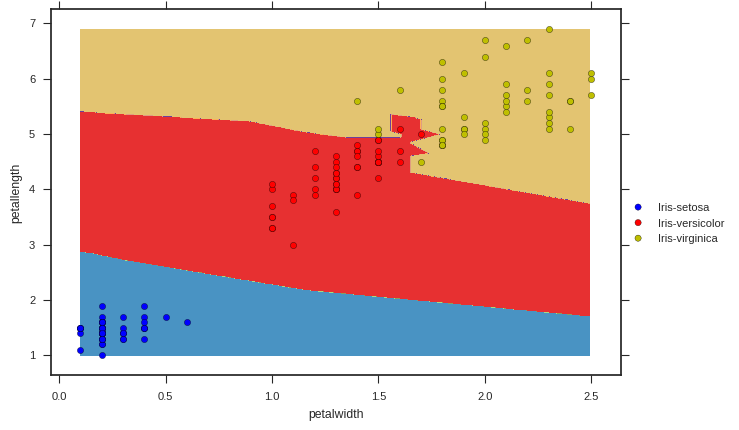

In [48]:
plot_decision_regions(clf, X, y, col_x="petalwidth", col_y="petallength")